In [1]:
import os
import pandas as pd
import numpy as np
import plotnine
from datetime import date
import scipy
import seaborn as sns
from Bio import SeqIO
import matplotlib.pyplot as plt
from upsetplot import from_memberships

## For figure panels C&D

In [10]:
matou_fold=os.path.join("/vortexfs1/omics/alexander","akrinos/2022-Krinos-eukrhythmic/MATOU/BLAST_MATOU",
                        "blast_out_matou/top_1")
output_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara"
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/09-CAG-mapping/salmon"
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/xx-CDS-mapping/salmon"
all_blast_file=pd.DataFrame()
all_salmon_sum=pd.DataFrame()
for dir_curr in os.listdir(matou_fold):
    #if not os.path.isfile(os.path.join(matou_fold,dir_curr,"combined","blast_formatted.out")):
    #    continue
    
    curr_sample = dir_curr.split("_CAG")[0]
    subdir = "EUKulele_merged_CAG_cds_14Mar22" #"EUKulele_merged"
    
    eggnog_CAG = pd.read_csv(os.path.join(output_dir, "eggnog_CAG", 
                       curr_sample + ".emapper.annotations"),
                                  sep="\t",comment="#",
                            header=None,names=["query","seed_ortholog","evalue","score",
                                               "eggNOG_OGs","max_annot_lvl","COG_category",
                                               "Description","Preferred_name","GOs","EC","KEGG_ko",
                                               "KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass",
                                               "BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"])
    
    EUKulele_file = pd.read_csv(os.path.join(output_dir,#subdir,
                                             subdir,
                                             "taxonomy_estimation",dir_curr.split("_CAG")[0]+\
                                             "_CAG-estimated-taxonomy.out"),sep="\t")
    
    eggnog_CAG = pd.read_csv(os.path.join(output_dir, "eggnog_CAG", 
                       curr_sample + ".emapper.annotations"),
                                  sep="\t",comment="#",
                            header=None,names=["query","seed_ortholog","evalue","score",
                                               "eggNOG_OGs","max_annot_lvl","COG_category",
                                               "Description","Preferred_name","GOs","EC","KEGG_ko",
                                               "KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass",
                                               "BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"])
    eggnog_CAG = eggnog_CAG.groupby("query")[["GOs","KEGG_ko"]].\
                    agg(lambda x: "-".join(sorted(list(set(x))))).reset_index(drop=False)
    eggnog_CAG["KEGG_ko"] = [str(curr) if str(curr) != "-" else \
                         "NoAnnot" for curr in eggnog_CAG.KEGG_ko]
    eggnog_CAG["GOs"] = [str(curr) if str(curr) != "-" else \
                         "NoAnnot" for curr in eggnog_CAG.GOs]
    
    EUKulele_file["split_tscpt_name"] = EUKulele_file["transcript_name"]
    
    salmon_file = pd.read_csv(os.path.join(salmon_dir,
                                           dir_curr.split("_CAG")[0] + "_CAG_quant",
                                           "quant.sf"),sep="\t")
    blast_file=pd.read_csv(os.path.join(matou_fold,dir_curr),
                                        #,"combined","blast_formatted.out"),
                                        #header=None,
                         #names=["qseqid","sseqid","pident","length","mismatch",
                         #       "gapopen","qstart","qend","sstart","send","evalue","bitscore"],
                           sep=",")
    blast_file["split_tscpt"] = [curr.split(".p")[0] for curr in blast_file.qseqid]
    blast_file=pd.merge(blast_file,salmon_file,how="right",left_on="qseqid",right_on="Name")
    blast_file=pd.merge(blast_file,EUKulele_file,how="left",left_on="Name",right_on="transcript_name")
    
    eggnog_CAG["split_tscpt_name_egg"] = [curr.split(".p")[0] for curr in eggnog_CAG["query"]]
    merged_kos = pd.merge(eggnog_CAG,blast_file, how="right",left_on="query",right_on="Name").drop("query",axis=1)
    
    merged_kos["KEGG_ko"] = ["NoAnnot" if curr!=curr else curr for curr in merged_kos.KEGG_ko]
    merged_kos["GOs"] = ["NoAnnot" if curr!=curr else curr for curr in merged_kos.GOs]
    merged_kos["Sample"] = dir_curr.split("_CAG")[0]

    merged_kos["HasMATOUMatch"] = ["Yes" if (curr == curr) else "No"\
                                   for curr in merged_kos.split_tscpt]
    merged_kos["HasEUKuleleAnnot"] = ["Yes" if (curr == curr) else "No"\
                                       for curr in merged_kos.classification]
    merged_kos["HasGOAnnot"] = ["Yes" if (curr != "NoAnnot") & (curr == curr) else "No"\
                                    for curr in merged_kos.GOs]
    merged_kos["HasKEGGAnnot"] = ["Yes" if (curr != "NoAnnot") & (curr == curr) else "No"\
                                    for curr in merged_kos.KEGG_ko]
    merged_kos["HasSalmonAnnot"] = "Yes"
    
    merged_kos = merged_kos[merged_kos.Length >= 150]
    merged_kos["Sample"] = dir_curr.split("_CAG")[0]
    salmon_sum = merged_kos.groupby(["HasSalmonAnnot","HasKEGGAnnot","Sample",
                                     "HasGOAnnot","HasEUKuleleAnnot",
                                     "HasMATOUMatch"])[["TPM","NumReads"]].sum()
    
    all_salmon_sum = pd.concat([all_salmon_sum,salmon_sum.reset_index()])
    all_blast_file = pd.concat([all_blast_file,merged_kos])

In [11]:
all_salmon_sum.to_csv(os.path.join("..","data-output","salmon_summed_reads.csv"))
all_blast_file.to_csv(os.path.join("..","data-output","all_blast_krinos_only.csv"))
all_blast_file[(all_blast_file.HasEUKuleleAnnot == "Yes") & \
               (all_blast_filet_file.HasMATOUMatch == "No")].to_csv(os.path.join("..","data-output","eukulele_only.csv"))

NameError: name 'all_blast_filet_file' is not defined

In [2]:
output_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara"
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/xx-individual-mapping/salmon"

## Read in BLAST searches against MATOU database

In [28]:
matou_fold=os.path.join("/vortexfs1/omics/alexander","akrinos/2022-Krinos-eukrhythmic/MATOU/BLAST_MATOU",
                        "blast_out_matou/top_1")
output_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara"
curr_sample = os.listdir(matou_fold)[0].split("_CAG")[0]
eggnog_CAG = pd.read_csv(os.path.join(output_dir, "eggnog_CAG", 
                       curr_sample + ".emapper.annotations"),
                                  sep="\t",comment="#",
                            header=None,names=["query","seed_ortholog","evalue","score",
                                               "eggNOG_OGs","max_annot_lvl","COG_category",
                                               "Description","Preferred_name","GOs","EC","KEGG_ko",
                                               "KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass",
                                               "BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"])

In [10]:

eggnog_CAG.groupby("query")["GOs","KEGG_ko"].agg({lambda x: "-".join(sorted(list(set(x))))}).reset_index()

<ipython-input-10-68aada124821>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,query,GOs,KEGG_ko
,,<lambda>,<lambda>
0,megahit_MS_SRF_SMALL_ERR1712006_k111_100004.p1,-,-
1,megahit_MS_SRF_SMALL_ERR1712006_k111_100015.p2,"GO:0000184,GO:0000956,GO:0001775,GO:0002181,GO...",ko:K02891
2,megahit_MS_SRF_SMALL_ERR1712006_k111_100018.p1,"GO:0000027,GO:0002181,GO:0003674,GO:0003676,GO...",ko:K02893
3,megahit_MS_SRF_SMALL_ERR1712006_k111_100043.p1,"GO:0003674,GO:0005488,GO:0005507,GO:0005575,GO...",ko:K02641
4,megahit_MS_SRF_SMALL_ERR1712006_k111_100044.p1,"GO:0003674,GO:0003824,GO:0004180,GO:0004181,GO...",-
...,...,...,...
144896,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN9997...,-,-
144897,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN999_...,-,-
144898,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN999_...,-,-


In [13]:
dir_curr=os.listdir(matou_fold)[0]
blast_file=pd.read_csv(os.path.join(matou_fold,dir_curr),
                                    #,"combined","blast_formatted.out"),
                                    #header=None,
                     #names=["qseqid","sseqid","pident","length","mismatch",
                     #       "gapopen","qstart","qend","sstart","send","evalue","bitscore"],
                       sep=",")
blast_file.head()

,Unnamed: 0,Unnamed: 0.1,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,4193,4193,megahit_MS_SRF_SMALL_ERR1712006_k111_1071.p1,MATOU-v1_11823997,86.420,162,20,2,46,206,34,194,5.490000e-43,176.0
1,4704,4704,megahit_MS_SRF_SMALL_ERR1712006_k111_108307.p1,MATOU-v1_11776798,97.465,355,3,2,1,354,551,202,7.380000e-171,601.0
2,4708,4708,megahit_MS_SRF_SMALL_ERR1712006_k111_108345.p1,MATOU-v1_11923206,93.137,612,34,6,68,672,1,611,0.000000e+00,891.0
3,5453,5453,megahit_MS_SRF_SMALL_ERR1712006_k111_109873.p1,MATOU-v1_11744000,87.071,379,41,5,1,375,143,517,6.560000e-117,422.0
4,5955,5955,megahit_MS_SRF_SMALL_ERR1712006_k111_110656.p1,MATOU-v1_11828381,90.311,289,26,2,13,300,537,250,1.130000e-103,377.0


In [26]:
eggnog_CAG

,GOs,KEGG_ko
,<lambda>,<lambda>
0,-,-
1,"GO:0000184,GO:0000956,GO:0001775,GO:0002181,GO...",ko:K02891
2,"GO:0000027,GO:0002181,GO:0003674,GO:0003676,GO...",ko:K02893
3,"GO:0003674,GO:0005488,GO:0005507,GO:0005575,GO...",ko:K02641
4,"GO:0003674,GO:0003824,GO:0004180,GO:0004181,GO...",-
...,...,...
144896,-,-
144897,-,-
144898,-,-


In [30]:
eggnog_CAG = eggnog_CAG.groupby("query")[["GOs","KEGG_ko"]].\
                    agg(lambda x: "-".join(sorted(list(set(x))))).reset_index(drop=False)
eggnog_CAG["KEGG_ko"] = [str(curr) if str(curr) != "-" else \
                         "NoAnnot" for curr in eggnog_CAG.KEGG_ko]
eggnog_CAG["GOs"] = [str(curr) if str(curr) != "-" else \
                         "NoAnnot" for curr in eggnog_CAG.GOs]

In [35]:
merged_kos = pd.merge(eggnog_CAG,blast_file, how="right",left_on="query",right_on="qseqid").drop("query",axis=1)
merged_kos["KEGG_ko"] = ["NoAnnot" if curr!=curr else curr for curr in merged_kos.KEGG_ko]
merged_kos["GOs"] = ["NoAnnot" if curr!=curr else curr for curr in merged_kos.GOs]

In [40]:
pd.set_option('display.max_colwidth', 80)
merged_kos[merged_kos.GOs == "NoAnnot"]

,GOs,KEGG_ko,Unnamed: 0,Unnamed: 0.1,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,NoAnnot,NoAnnot,65081646,2,megahit_MS_SRF_SMALL_ERR1712006_k111_100004.p1,MATOU-v1_52544753,99.716,704,2,0,26,729,1,704,0.000000e+00,1290.0
6,NoAnnot,NoAnnot,28990581,5,megahit_MS_SRF_SMALL_ERR1712006_k111_100046.p1,MATOU-v1_71087013,93.617,517,30,3,1,515,83,598,0.000000e+00,769.0
7,NoAnnot,NoAnnot,92602429,5,megahit_MS_SRF_SMALL_ERR1712006_k111_100046.p1,MATOU-v1_28905628,93.617,517,30,3,1,515,1350,835,0.000000e+00,769.0
8,NoAnnot,ko:K02639,13928094,247,megahit_MS_SRF_SMALL_ERR1712006_k111_100047.p1,MATOU-v1_26989411,99.481,385,2,0,6,390,16,400,0.000000e+00,701.0
9,NoAnnot,NoAnnot,11620410,249,megahit_MS_SRF_SMALL_ERR1712006_k111_100050.p2,MATOU-v1_38801851,100.000,291,0,0,40,330,1,291,3.830000e-152,538.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328203,NoAnnot,NoAnnot,133232253,1163125,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN89329_c0_g1_i1.p1,MATOU-v1_10571081,99.753,405,1,0,1,405,8044,7640,0.000000e+00,743.0
328204,NoAnnot,NoAnnot,133232851,1163723,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN92177_c0_g1_i1.p2,MATOU-v1_10585748,99.379,322,2,0,12,333,1036,1357,8.610000e-166,584.0
328205,NoAnnot,NoAnnot,133232923,1163795,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN92591_c0_g1_i1.p2,MATOU-v1_10699570,82.432,296,50,2,11,305,181,475,1.940000e-67,257.0
328206,NoAnnot,NoAnnot,133233124,1163996,trinity_MS_SRF_SMALL_ERR1712006_TRINITY_DN92845_c0_g1_i1.p1,MATOU-v1_10574344,99.091,330,3,0,1,330,1596,1925,1.420000e-168,593.0


In [87]:
matou_fold=os.path.join("/vortexfs1/omics/alexander","akrinos/2022-Krinos-eukrhythmic/MATOU/BLAST_MATOU",
                        "blast_out_matou/top_1")
output_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara"
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/09-CAG-mapping/salmon"
all_blast_file=pd.DataFrame()
for dir_curr in os.listdir(matou_fold):
    #if not os.path.isfile(os.path.join(matou_fold,dir_curr,"combined","blast_formatted.out")):
    #    continue
    
    curr_sample = dir_curr.split("_CAG")[0]
    subdir = "EUKulele_merged"
    
    eggnog_CAG = pd.read_csv(os.path.join(output_dir, "eggnog_CAG", 
                       curr_sample + ".emapper.annotations"),
                                  sep="\t",comment="#",
                            header=None,names=["query","seed_ortholog","evalue","score",
                                               "eggNOG_OGs","max_annot_lvl","COG_category",
                                               "Description","Preferred_name","GOs","EC","KEGG_ko",
                                               "KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass",
                                               "BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"])
    
    EUKulele_file = pd.read_csv(os.path.join(output_dir,#subdir,
                                             subdir,
                                             "taxonomy_estimation",dir_curr.split("_CAG")[0]+\
                                             "_merged-estimated-taxonomy.out"),sep="\t")
    
    eggnog_CAG = pd.read_csv(os.path.join(output_dir, "eggnog_CAG", 
                       curr_sample + ".emapper.annotations"),
                                  sep="\t",comment="#",
                            header=None,names=["query","seed_ortholog","evalue","score",
                                               "eggNOG_OGs","max_annot_lvl","COG_category",
                                               "Description","Preferred_name","GOs","EC","KEGG_ko",
                                               "KEGG_Pathway","KEGG_Module","KEGG_Reaction","KEGG_rclass",
                                               "BRITE","KEGG_TC","CAZy","BiGG_Reaction","PFAMs"])
    eggnog_CAG = eggnog_CAG.groupby("query")[["GOs","KEGG_ko"]].\
                    agg(lambda x: "-".join(sorted(list(set(x))))).reset_index(drop=False)
    eggnog_CAG["KEGG_ko"] = [str(curr) if str(curr) != "-" else \
                         "NoAnnot" for curr in eggnog_CAG.KEGG_ko]
    eggnog_CAG["GOs"] = [str(curr) if str(curr) != "-" else \
                         "NoAnnot" for curr in eggnog_CAG.GOs]
    
    EUKulele_file["split_tscpt_name"] = EUKulele_file["transcript_name"]
    
    salmon_file = pd.read_csv(os.path.join(salmon_dir,
                                           dir_curr.split("_CAG")[0] + "_quant",
                                           "quant.sf"),sep="\t")
    blast_file=pd.read_csv(os.path.join(matou_fold,dir_curr),
                                        #,"combined","blast_formatted.out"),
                                        #header=None,
                         #names=["qseqid","sseqid","pident","length","mismatch",
                         #       "gapopen","qstart","qend","sstart","send","evalue","bitscore"],
                           sep=",")
    blast_file["split_tscpt"] = [curr.split(".p")[0] for curr in blast_file.qseqid]
    blast_file=pd.merge(blast_file,salmon_file,how="right",left_on="split_tscpt",right_on="Name")
    blast_file=pd.merge(blast_file,EUKulele_file,how="left",left_on="Name",right_on="split_tscpt_name")
    
    eggnog_CAG["split_tscpt_name"] = [curr.split(".p")[0] for curr in eggnog_CAG["query"]]
    merged_kos = pd.merge(eggnog_CAG,blast_file, how="right",left_on="split_tscpt_name",right_on="Name").drop("query",axis=1)
    merged_kos["KEGG_ko"] = ["NoAnnot" if curr!=curr else curr for curr in merged_kos.KEGG_ko]
    merged_kos["GOs"] = ["NoAnnot" if curr!=curr else curr for curr in merged_kos.GOs]
    merged_kos["Sample"] = dir_curr.split("_CAG")[0]
    
    all_blast_file = pd.concat([all_blast_file,merged_kos])
    

In [104]:
blast_file[["Name","qseqid","sseqid"]].head()

,Name,qseqid,sseqid
0,megahit_MS_SRF_SMALL_ERR550404_k111_10034,megahit_MS_SRF_SMALL_ERR550404_k111_10034.p1,MATOU-v1_11834237
1,megahit_MS_SRF_SMALL_ERR550404_k111_11756,megahit_MS_SRF_SMALL_ERR550404_k111_11756.p1,MATOU-v1_11557110
2,megahit_MS_SRF_SMALL_ERR550404_k111_12605,megahit_MS_SRF_SMALL_ERR550404_k111_12605.p1,MATOU-v1_11863571
3,megahit_MS_SRF_SMALL_ERR550404_k111_13182,megahit_MS_SRF_SMALL_ERR550404_k111_13182.p1,MATOU-v1_11674438
4,megahit_MS_SRF_SMALL_ERR550404_k111_14067,megahit_MS_SRF_SMALL_ERR550404_k111_14067.p1,MATOU-v1_11572768


In [105]:
eggnog_CAG.head()

,query,GOs,KEGG_ko
0,megahit_MS_SRF_SMALL_ERR550404_k111_100.p1,NoAnnot,"ko:K18595,ko:K18598"
1,megahit_MS_SRF_SMALL_ERR550404_k111_1000.p1,"GO:0000003,GO:0000323,GO:0001505,GO:0001558,GO:0001708,GO:0002084,GO:0003008,GO:0003674,GO:00038...",ko:K01074
2,megahit_MS_SRF_SMALL_ERR550404_k111_10003.p1,NoAnnot,ko:K03798
3,megahit_MS_SRF_SMALL_ERR550404_k111_10004.p2,NoAnnot,ko:K02703
4,megahit_MS_SRF_SMALL_ERR550404_k111_10007.p1,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO:0005886,GO:0009521,GO:0009523,GO:0009579,GO:00160...",ko:K02705


In [88]:
all_blast_file.columns

Index(['GOs', 'KEGG_ko', 'Unnamed: 0_x', 'Unnamed: 0.1', 'qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'split_tscpt', 'Name', 'Length', 'EffectiveLength', 'TPM', 'NumReads', 'Unnamed: 0_y', 'transcript_name', 'classification_level', 'full_classification', 'classification', 'max_pid', 'ambiguous', 'counts', 'split_tscpt_name', 'Sample'], dtype='object')

In [16]:
all_blast_file[all_blast_file.Sample == "SO_SRF_SMALL_ERR1719157"].sort_values("NumReads",ascending=False)

,Unnamed: 0_x,Unnamed: 0.1,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,...,classification_level,full_classification,classification,max_pid,ambiguous,counts,split_tscpt_name,Sample,HasMATOUMatch,HasEUKuleleAnnot
206873,55478335.0,261877.0,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_18406_length_1729_cov_3072.129762_g2286_i2.p1,MATOU-v1_109070604,99.679,312.0,1.0,0.0,1.0,312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SO_SRF_SMALL_ERR1719157,Yes,No
206875,74827758.0,732616.0,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_18406_length_1729_cov_3072.129762_g2286_i2.p1,MATOU-v1_113632352,99.679,312.0,1.0,0.0,1.0,312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SO_SRF_SMALL_ERR1719157,Yes,No
206876,143625477.0,257583.0,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_18406_length_1729_cov_3072.129762_g2286_i2.p1,MATOU-v1_110418510,99.679,312.0,1.0,0.0,1.0,312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SO_SRF_SMALL_ERR1719157,Yes,No
206874,62695951.0,1637928.0,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_18406_length_1729_cov_3072.129762_g2286_i2.p1,MATOU-v1_112706045,99.679,312.0,1.0,0.0,1.0,312.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SO_SRF_SMALL_ERR1719157,Yes,No
2077832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SO_SRF_SMALL_ERR1719157,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963697,124629078.0,24573.0,megahit_SO_SRF_SMALL_ERR1719157_k111_148617.p1,MATOU-v1_116108065,98.111,1059.0,2.0,1.0,1.0,1041.0,...,family,Eukaryota; Hacrobia; Haptophyta; Prymnesiophyceae; Phaeocystales; Phaeocystaceae,Phaeocystaceae,65.5,0.0,NaN,megahit_SO_SRF_SMALL_ERR1719157_k111_148617,SO_SRF_SMALL_ERR1719157,Yes,Yes
963695,124629073.0,24568.0,megahit_SO_SRF_SMALL_ERR1719157_k111_148593.p1,MATOU-v1_115800600,95.607,387.0,12.0,5.0,1.0,384.0,...,family,Eukaryota; Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Raphid-pennate,Raphid-pennate,77.7,0.0,NaN,megahit_SO_SRF_SMALL_ERR1719157_k111_148593,SO_SRF_SMALL_ERR1719157,Yes,Yes
328448,62353332.0,1295309.0,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_111200_length_749_cov_1.774286_g98929_i0.p1,MATOU-v1_112728908,99.866,747.0,1.0,0.0,1.0,747.0,...,order,Eukaryota; Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X,Bacillariophyta_X,64.1,0.0,NaN,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_111200_length_749_cov_1.774286_g98929_i0,SO_SRF_SMALL_ERR1719157,Yes,Yes
328453,62353342.0,1295319.0,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_111208_length_749_cov_1.712857_g98937_i0.p1,MATOU-v1_112460438,98.929,747.0,8.0,0.0,1.0,747.0,...,class,Eukaryota; Alveolata; Dinoflagellata; Dinophyceae,Dinophyceae,42.9,0.0,NaN,rnaspades_SO_SRF_SMALL_ERR1719157_NODE_111208_length_749_cov_1.712857_g98937_i0,SO_SRF_SMALL_ERR1719157,Yes,Yes


In [89]:
all_blast_file["HasMATOUMatch"] = ["Yes" if (curr == curr) else "No"\
                                   for curr in all_blast_file.split_tscpt]
all_blast_file["HasEUKuleleAnnot"] = ["Yes" if (curr == curr) else "No"\
                                   for curr in all_blast_file.classification]
all_blast_file["HasGOAnnot"] = ["Yes" if (curr != "NoAnnot") & (curr == curr) else "No"\
                                for curr in all_blast_file.GOs]
all_blast_file["HasKEGGAnnot"] = ["Yes" if (curr != "NoAnnot") & (curr == curr) else "No"\
                                for curr in all_blast_file.KEGG_ko]
(plotnine.ggplot(all_blast_file) + plotnine.geom_boxplot(plotnine.aes(x = "HasMATOUMatch",
                                                                      y = "Length")) + plotnine.scale_y_log10())

MemoryError: Unable to allocate 4.36 GiB for an array with shape (16, 36601939) and data type object

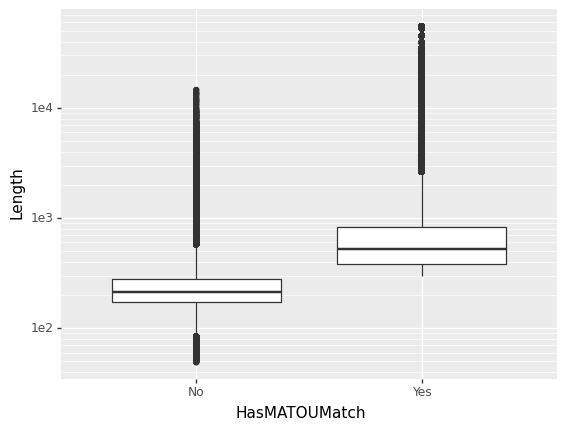

<ggplot: (2932272508823)>

In [7]:

(plotnine.ggplot(all_blast_file) + plotnine.geom_boxplot(plotnine.aes(x = "HasMATOUMatch",
                                                                      y = "Length")) + plotnine.scale_y_log10())

In [93]:
pd.set_option('max_colwidth', 100)

all_blast_file.loc[(all_blast_file.HasEUKuleleAnnot == "No"),
                   ["qseqid","sseqid","Sample","HasMATOUMatch","HasEUKuleleAnnot","HasGOAnnot","TPM","Name"]].head()

MemoryError: Unable to allocate 5.18 GiB for an array with shape (19, 36601939) and data type float64

In [62]:
all_grouped_pivoted = all_blast_file.groupby(["HasMATOUMatch","HasEUKuleleAnnot","HasGOAnnot",
                                              "HasKEGGAnnot",
                                        "Sample"])["TPM"].sum().reset_index()
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "No") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "No") &
                    (all_grouped_pivoted.HasGOAnnot == "No") &
                    (all_grouped_pivoted.HasKEGGAnnot == "No"),"Category"] = "NoMATOU-NoEUKulele-NoFunctional"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "No") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "No") &
                    ((all_grouped_pivoted.HasGOAnnot == "Yes") |
                    (all_grouped_pivoted.HasKEGGAnnot == "Yes")),"Category"] = "NoMATOU-NoEUKulele-Functional"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "No") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "No") &
                    (all_grouped_pivoted.HasGOAnnot == "Yes") &
                    (all_grouped_pivoted.HasKEGGAnnot == "No"),"Category"] = "NoMATOU-NoEUKulele-HasGO"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "No") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "No") &
                    (all_grouped_pivoted.HasGOAnnot == "Yes") &
                    (all_grouped_pivoted.HasKEGGAnnot == "Yes"),"Category"] = "NoMATOU-NoEUKulele-HasKEGGandGO"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "Yes") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "No"),"Category"] = "MATOU-NoEUKulele"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "Yes") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "No") &
                    (all_grouped_pivoted.HasGOAnnot == "Yes"),"Category"] = "MATOU-NoEUKulele-HasGO"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "Yes") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "Yes"),"Category"] = "MATOU-EUKulele"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "No") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "Yes")&
                    ((all_grouped_pivoted.HasGOAnnot == "Yes") | 
                     (all_grouped_pivoted.HasKEGGAnnot == "Yes")),"Category"] = "NoMATOU-EUKulele-Function"
all_grouped_pivoted.loc[(all_grouped_pivoted.HasMATOUMatch == "No") &
                    (all_grouped_pivoted.HasEUKuleleAnnot == "Yes") &
                    (all_grouped_pivoted.HasGOAnnot == "No") &
                    (all_grouped_pivoted.HasKEGGAnnot == "No"),"Category"] = "NoMATOU-EUKulele-NoFunctional"
all_grouped_unpivoted = all_grouped_pivoted.copy(deep="true")
#all_grouped_pivoted = all_grouped_pivoted.\
#                    pivot(index='Sample',columns="Category", values="TPM")

In [72]:
all_blast_file.loc[(all_blast_file.HasMATOUMatch == "No") &
                    (all_blast_file.HasEUKuleleAnnot == "No") &
                    (all_blast_file.HasGOAnnot == "No") &
                    (all_blast_file.HasKEGGAnnot == "No"),["Name","Sample","HasMATOUMatch",
                                                           "HasEUKuleleAnnot"]]

,Name,Sample,HasMATOUMatch,HasEUKuleleAnnot
328214,megahit_MS_SRF_SMALL_ERR1712006_k111_4,MS_SRF_SMALL_ERR1712006,No,No
328215,megahit_MS_SRF_SMALL_ERR1712006_k111_78681,MS_SRF_SMALL_ERR1712006,No,No
328216,megahit_MS_SRF_SMALL_ERR1712006_k111_236031,MS_SRF_SMALL_ERR1712006,No,No
328217,megahit_MS_SRF_SMALL_ERR1712006_k111_118032,MS_SRF_SMALL_ERR1712006,No,No
328219,megahit_MS_SRF_SMALL_ERR1712006_k111_39389,MS_SRF_SMALL_ERR1712006,No,No
...,...,...,...,...
285713,trinity_MS_SRF_SMALL_ERR550404_TRINITY_DN111_c0_g1_i17,MS_SRF_SMALL_ERR550404,No,No
285717,trinity_MS_SRF_SMALL_ERR550404_TRINITY_DN10116_c0_g1_i1,MS_SRF_SMALL_ERR550404,No,No
285719,trinity_MS_SRF_SMALL_ERR550404_TRINITY_DN24879_c0_g1_i1,MS_SRF_SMALL_ERR550404,No,No
285720,trinity_MS_SRF_SMALL_ERR550404_TRINITY_DN24826_c0_g1_i1,MS_SRF_SMALL_ERR550404,No,No


In [65]:
all_grouped_pivoted.to_csv(os.path.join("..","data-output","all_grouped_pivoted.csv"))

In [96]:
len(all_blast_file.index)

36601939

In [94]:
all_blast_file_dropped = all_blast_file.drop_duplicates(subset=["split_tscpt_name","HasMATOUMatch",
               "HasEUKuleleAnnot","HasGOAnnot",
               "HasKEGGAnnot","Sample","Name"])

MemoryError: Unable to allocate 4.36 GiB for an array with shape (16, 36601939) and data type object

In [79]:
len(all_blast_file_dropped[all_blast_file_dropped.Length>=150].index)

35835695

In [75]:
len(all_blast_file_dropped.index)

35861466

In [97]:
all_blast_file[(all_blast_file.HasGOAnnot=="Yes") & \
                       (all_blast_file.HasEUKuleleAnnot=="Yes") &
                       (all_blast_file.HasMATOUMatch=="No")]

MemoryError: Unable to allocate 5.18 GiB for an array with shape (19, 36601939) and data type float64

In [98]:
all_blast_file.loc[(all_blast_file_dropped.Length>=150),["split_tscpt_name","HasMATOUMatch",
               "HasEUKuleleAnnot","HasGOAnnot",
               "HasKEGGAnnot","Sample","Name"]].to_csv(os.path.join("..","data-output","all_blast_file_length_cutoff_150bp.csv"))

KeyboardInterrupt: 

In [101]:
all_blast_file.Name[1]

1     megahit_MS_SRF_SMALL_ERR1712006_k111_108307
1     megahit_SO_SRF_SMALL_ERR1740133_k111_168037
1     megahit_SO_SRF_SMALL_ERR1719157_k111_133343
1       megahit_MS_SRF_SMALL_ERR550386_k111_10908
1     megahit_SO_SRF_SMALL_ERR1712028_k111_100012
1    megahit_MS_SRF_SMALL_ERR1711918_k111_1000670
1     megahit_MS_SRF_SMALL_ERR1712022_k111_100722
1     megahit_SO_SRF_SMALL_ERR1740115_k111_336224
1      megahit_MS_SRF_SMALL_ERR550403_k111_100150
1     megahit_MS_SRF_SMALL_ERR1711995_k111_100114
1    megahit_SO_SRF_SMALL_ERR1740130_k111_1003648
1       megahit_MS_SRF_SMALL_ERR550404_k111_11756
Name: Name, dtype: object

In [100]:
counted_cats = all_blast_file.loc[(all_blast_file_dropped.Length>=150),["split_tscpt_name","HasMATOUMatch",
               "HasEUKuleleAnnot","HasGOAnnot",
               "HasKEGGAnnot","Sample","Name"]].groupby(["HasMATOUMatch",
               "HasEUKuleleAnnot","HasGOAnnot",
               "HasKEGGAnnot","Sample"])["Name"].count().reset_index()

KeyboardInterrupt: 

In [80]:
all_blast_file_dropped[all_blast_file_dropped.Length>=150][["split_tscpt_name","HasMATOUMatch",
               "HasEUKuleleAnnot","HasGOAnnot","Length",
               "HasKEGGAnnot","Sample","Name"]].to_csv(os.path.join("..","data-output","all_blast_file_length_cutoff_150bp.csv"))

In [46]:
set(all_grouped_unpivoted.Sample)

{'MS_SRF_SMALL_ERR1711918',
 'MS_SRF_SMALL_ERR1711995',
 'MS_SRF_SMALL_ERR1712006',
 'MS_SRF_SMALL_ERR1712022',
 'MS_SRF_SMALL_ERR550386',
 'MS_SRF_SMALL_ERR550403',
 'MS_SRF_SMALL_ERR550404',
 'SO_SRF_SMALL_ERR1712028',
 'SO_SRF_SMALL_ERR1719157',
 'SO_SRF_SMALL_ERR1740115',
 'SO_SRF_SMALL_ERR1740130',
 'SO_SRF_SMALL_ERR1740133'}

In [11]:
set(all_grouped_unpivoted.Sample)

{'MS_SRF_SMALL_ERR1711995',
 'MS_SRF_SMALL_ERR550386',
 'MS_SRF_SMALL_ERR550403',
 'MS_SRF_SMALL_ERR550404',
 'SO_SRF_SMALL_ERR1712028',
 'SO_SRF_SMALL_ERR1719157',
 'SO_SRF_SMALL_ERR1740115'}

In [63]:
all_grouped_unpivoted[all_grouped_unpivoted.Category != all_grouped_unpivoted.Category]

,HasMATOUMatch,HasEUKuleleAnnot,HasGOAnnot,HasKEGGAnnot,Sample,TPM,Category


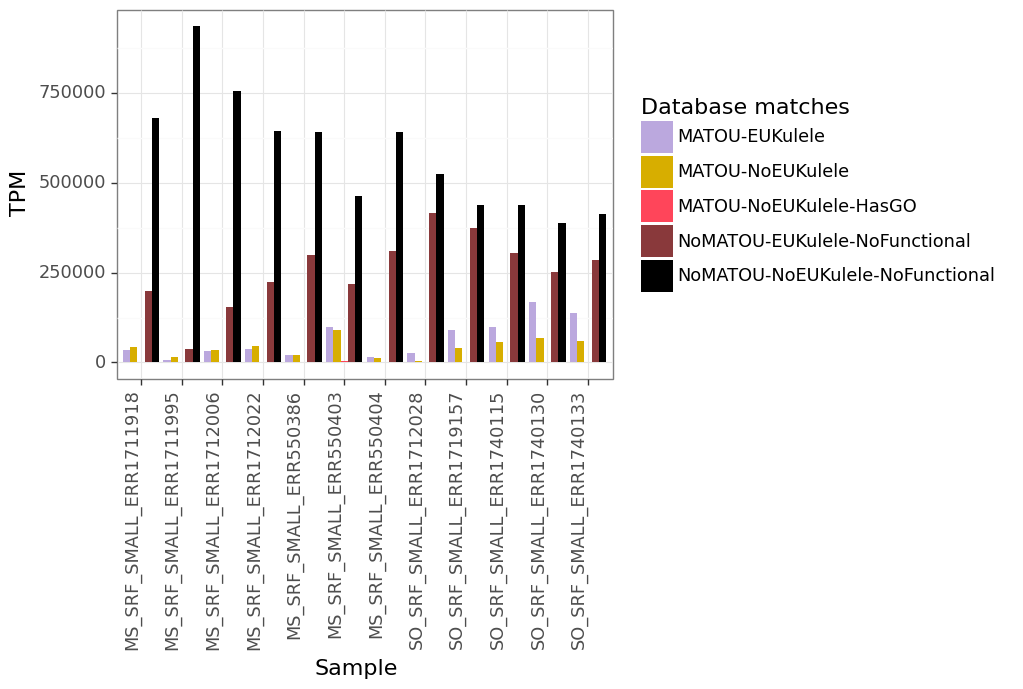

<ggplot: (2932735817623)>

In [64]:
(plotnine.ggplot(all_grouped_unpivoted) + 
     plotnine.geom_bar(plotnine.aes(x = "Sample",
                                      y = "TPM",fill="Category",group="Category"),
                       stat="identity",position="dodge") + 
     plotnine.theme_bw(base_size=16) + 
     plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1))+
     plotnine.scale_fill_manual(values=["#bba8de",
"#d7ae00",
"#ff455a",
"#89393b","black","white","blue"],name="Database matches"))

In [51]:
(plotnine.ggplot(all_grouped_unpivoted) + 
     plotnine.geom_bar(plotnine.aes(x = "Sample",
                                      y = "TPM",fill="Category",group="Category"),
                       stat="identity",position="dodge") + 
     plotnine.theme_bw(base_size=16) + 
     plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1))+
     plotnine.scale_fill_manual(values=["#bba8de",
"#d7ae00",
"#ff455a",
"#89393b"],name="Database matches"))

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/scales/scale_manual.py:27: PlotnineWarning: Palette can return a maximum of 4 values. 5 were requested from it.


AttributeError: 'float' object has no attribute 'lower'

In [48]:
all_grouped_pivoted = all_grouped_pivoted.reset_index()
all_grouped_pivoted.head()ß=

Category,Sample,MATOU-EUKulele,MATOU-NoEUKulele,NoMATOU-EUKulele,NoMATOU-NoEUKulele
0,MS_SRF_SMALL_ERR550386,54134.063027,21956.832512,297989.237077,641427.695534
1,MS_SRF_SMALL_ERR550403,263513.052863,97340.587231,218225.638553,463926.106670
2,SO_SRF_SMALL_ERR1712028,58712.512510,3053.889181,416279.068654,523550.439291
3,SO_SRF_SMALL_ERR1719157,163060.141112,44078.620291,373798.774313,438089.714501
4,SO_SRF_SMALL_ERR1740115,222595.098137,60269.958583,304245.704116,438133.725440


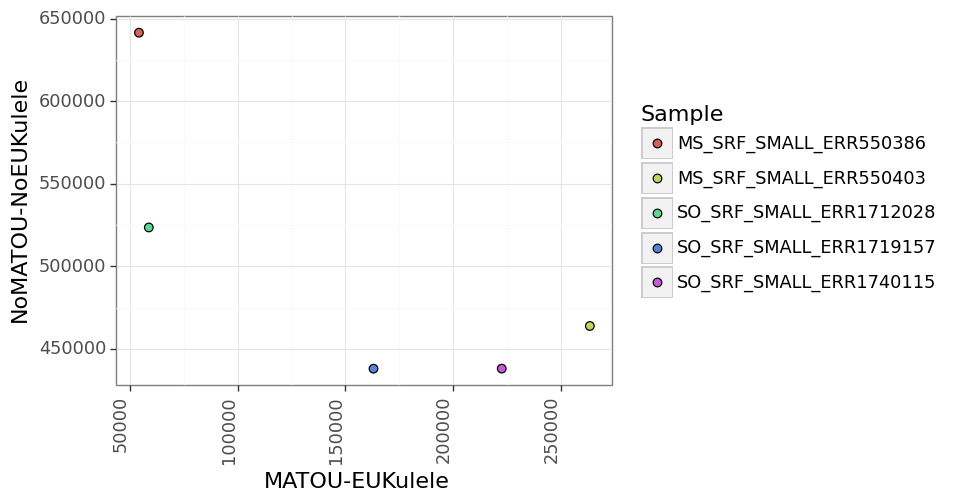

<ggplot: (2933373613319)>

In [49]:
(plotnine.ggplot(all_grouped_pivoted) + 
     plotnine.geom_point(plotnine.aes(x = "MATOU-EUKulele",
                                    y = "NoMATOU-NoEUKulele",fill="Sample"),size=3) + 
     plotnine.theme_bw(base_size=16) + 
     plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1)))

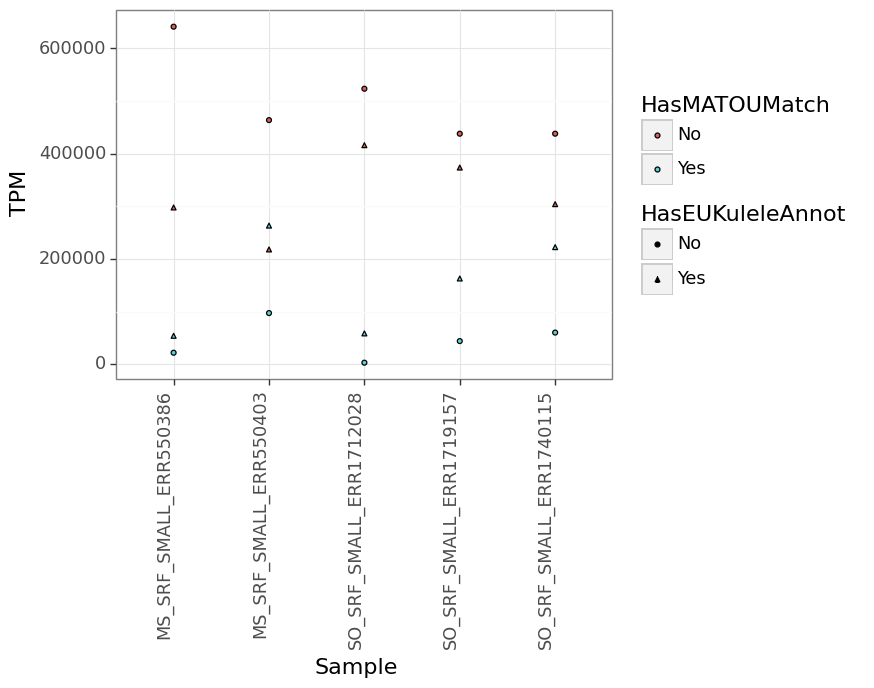

<ggplot: (2933373417313)>

In [44]:
(plotnine.ggplot(all_blast_file.groupby(["HasMATOUMatch","HasEUKuleleAnnot",
                                        "Sample"])["TPM"].sum().reset_index()) + 
     plotnine.geom_point(plotnine.aes(fill = "HasMATOUMatch",
                                    y = "TPM",x="Sample",shape="HasEUKuleleAnnot")) + 
     plotnine.theme_bw(base_size=16) + 
     plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1)))

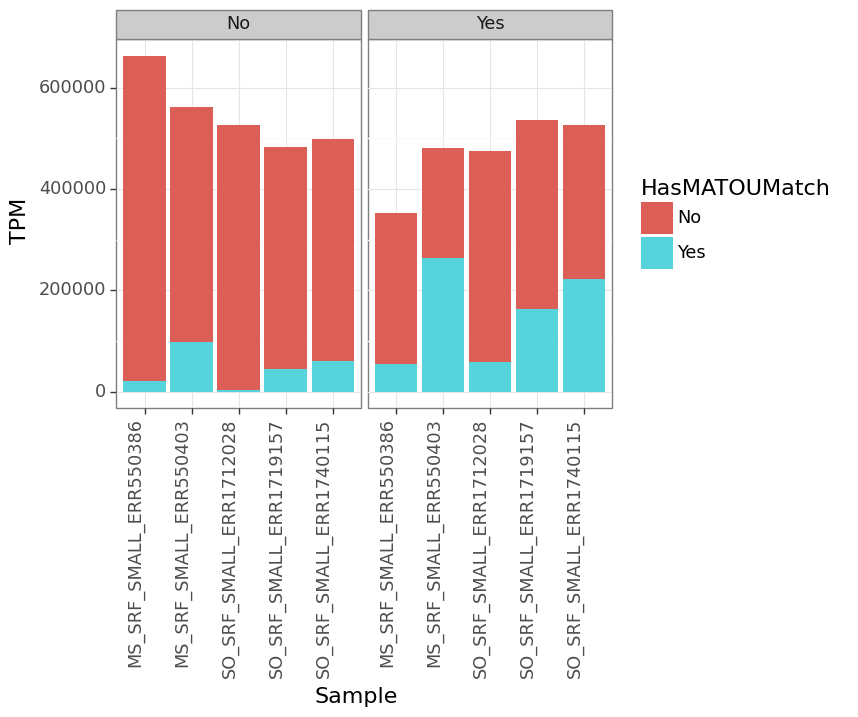

<ggplot: (2932389049251)>

In [35]:

(plotnine.ggplot(all_blast_file.groupby(["HasMATOUMatch","HasEUKuleleAnnot",
                                        "Sample"])["TPM"].sum().reset_index()) + 
     plotnine.geom_bar(plotnine.aes(fill = "HasMATOUMatch",
                                    y = "TPM",x="Sample"),stat="identity") + 
     plotnine.theme_bw(base_size=16) + 
     plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1)) +
     plotnine.facet_wrap("HasEUKuleleAnnot"))

In [19]:
os.listdir(os.path.join(output_dir,'EUKulele_assemblers'))

['EUKulele_megahit', 'EUKulele_trinity', 'EUKulele_rnaspades']

In [6]:
os.listdir(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,"taxonomy_estimation"))

['SO_SRF_SMALL_ERR1740130_rnaspades_renamed-estimated-taxonomy.out',
 'SO_SRF_SMALL_ERR1719157_rnaspades_renamed-estimated-taxonomy.out',
 'SO_SRF_SMALL_ERR1740133_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1711995_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR550403_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1711918_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1711998_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR550404_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1712022_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1719224_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR550386_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1712006_rnaspades_renamed-estimated-taxonomy.out',
 'SO_SRF_SMALL_ERR1740115_rnaspades_renamed-estimated-taxonomy.out',
 'SO_SRF_SMALL_ERR1712028_rnaspades_renamed-estimated-taxonomy.out',
 'MS_SRF_SMALL_ERR1719164_rnaspades_r

In [8]:
curr_file

'MS_SRF_SMALL_ERR1711998_rnaspades_renamed-estimated-taxonomy.out'

In [21]:
curr_folder=os.listdir(os.path.join(output_dir,'EUKulele_assemblers'))[2]
curr_assembler = curr_folder.split("EUKulele_")[-1]
curr_file=os.listdir(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,"taxonomy_estimation"))[6]

curr_sample = curr_file.split("_" + curr_assembler)[0]
EUKulele_file = pd.read_csv(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,
                                         "taxonomy_estimation",curr_file),sep="\t")
#EUKulele_file["split_tscpt_name"] = [curr.split(curr_sample + "_")[-1] for curr in \
#                                     EUKulele_file["transcript_name"]]
EUKulele_file[["AssemblerSamp","split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split(curr_assembler+"_"+curr_sample+"_", n=1, expand=True)
#salmon_file = pd.read_csv(os.path.join(salmon_dir,curr_sample+"_"+curr_assembler+"_quant",
#                                       "quant.sf"),sep="\t")
EUKulele_file = pd.merge(EUKulele_file,salmon_all.loc[(salmon_all["Sample"] == curr_sample) & \
                                                      (salmon_all["Assembler"] == curr_assembler),:],
                         left_on="split_tscpt_name",right_on="Name",
                         how = "right")

In [25]:
EUKulele_file[EUKulele_file.Genus == "Unknown"]

,Order,Domain,Phylum,Class,Family,Genus,TPMcount,TPMsum,Sample,Assembler


In [22]:
EUKulele_file.loc[EUKulele_file.full_classification != EUKulele_file.full_classification,
                  "full_classification"] = "Unclassified;Unclassified;Unclassified;" + \
            "Unclassified;Unclassified;Unclassified;Unclassified;Unclassified"
class_labels = ["Domain","Supergroup","Phylum","Class","Order",
            "Family","Genus","Species"]
print("prestep",flush=True)
EUKulele_file[class_labels]= EUKulele_file["full_classification"].\
                                    str.split(";", n = 8, expand = True)
print("step1",flush=True)
#for class_label in class_labels:
#    EUKulele_file.loc[[curr is None for curr in EUKulele_file[class_label]],class_label] = "Unknown"
#for class_label in class_labels:
#    EUKulele_file.loc[EUKulele_file[class_label].isnull(),class_label] = "Unknown"
EUKulele_file = EUKulele_file.fillna(value=np.nan)
print("step2",flush=True)
EUKulele_file_full = EUKulele_file.copy(deep=True)
EUKulele_file_full["Sample"] = curr_sample
EUKulele_file_full["Assembler"] = curr_assembler
EUKulele_file = EUKulele_file.groupby(["Order","Domain",
                                       "Phylum","Class","Family","Genus"]).agg({'TPM': ['count',
                                                                       'sum']}).reset_index()
print("step3",flush=True)
#EUKulele_file = EUKulele_file.groupby(["Order","Domain",
#                                       "Phylum","Class","Family","Genus"]).agg({'split_tscpt_name': ['count']}).reset_index()
EUKulele_file.columns = ["".join(col) for col in EUKulele_file.columns.values]
EUKulele_file["Sample"] = curr_sample
EUKulele_file["Assembler"] = curr_assembler

prestep
step1
step2
step3


In [7]:
EUKulele_frame = pd.DataFrame()
EUKulele_frame_full = pd.DataFrame()
output_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara"
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/09-CAG-mapping/salmon"

subdir = "EUKulele_merged"#"EUKulele_assemblers"
for curr_folder in os.listdir(os.path.join(output_dir)):
    curr_assembler = curr_folder.split("_merged")[0] #"EUKulele_")[-1]
    if curr_folder != subdir:
        continue
    for curr_file in os.listdir(os.path.join(output_dir,#subdir,
                                             curr_folder,"taxonomy_estimation")):
        curr_sample = curr_file.split("_merged")[0] #+ #curr_assembler)[0]
        EUKulele_file = pd.read_csv(os.path.join(output_dir,#subdir,
                                                 curr_folder,
                                                 "taxonomy_estimation",curr_file),sep="\t")
        #EUKulele_file[["AssemblerSamp",
        #               "split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split(curr_assembler+"_"+curr_sample+"_", 
        #                                                                                 n=1, expand=True)
        
        EUKulele_file["split_tscpt_name"] = EUKulele_file["transcript_name"]
        #[curr.split(".p")[0] for curr in EUKulele_file["transcript_name"]]
        #[curr.split(curr_sample + "_")[-1] for curr in \
        #                                     EUKulele_file["transcript_name"]]
        salmon_file = pd.read_csv(os.path.join(salmon_dir,
                                               curr_sample + "_quant",
                                               #curr_sample+"_"+curr_assembler+"_quant",
                                               "quant.sf"),sep="\t")
        EUKulele_file = pd.merge(EUKulele_file,salmon_file,left_on="split_tscpt_name",right_on="Name",
                                 how = "right")
        #EUKulele_file["split_tscpt_name"] = [curr.split(curr_sample + "_")[-1] for curr in \
        #                                     EUKulele_file["transcript_name"]]
        #salmon_file = pd.read_csv(os.path.join(salmon_dir,curr_sample+"_"+curr_assembler+"_quant",
        #                                       "quant.sf"),sep="\t")
        #EUKulele_file = pd.merge(EUKulele_file,salmon_all.loc[(salmon_all["Sample"] == curr_sample) & \
        #                                                      (salmon_all["Assembler"] == curr_assembler),:],
        #                         left_on="split_tscpt_name",right_on="Name",
        #                         how = "right")
        EUKulele_file.loc[EUKulele_file.full_classification != EUKulele_file.full_classification,
                          "full_classification"] = "Unclassified;Unclassified;Unclassified;" + \
                    "Unclassified;Unclassified;Unclassified;Unclassified;Unclassified"
        class_labels = ["Domain","Supergroup","Phylum","Class","Order",
                    "Family","Genus","Species"]
        EUKulele_file[class_labels]= EUKulele_file["full_classification"].\
                                            str.split(";", n = 8, expand = True)
        #for class_label in class_labels:
        #    EUKulele_file.loc[EUKulele_file[class_label].isnull(),class_label] = "Unknown"
        EUKulele_file = EUKulele_file.fillna(value="Unknown")
            #EUKulele_file.loc[[curr is None for curr in EUKulele_file[class_label]],class_label] = "Unknown"
        EUKulele_file_full = EUKulele_file.copy(deep=True)
        EUKulele_file_full["Sample"] = curr_sample
        EUKulele_file_full["Assembler"] = curr_assembler
        EUKulele_file = EUKulele_file.groupby(["Order","Domain",
                                               "Phylum","Class","Family","Genus"]).agg({'TPM': ['count',
                                                                               'sum'],
                                                                'NumReads':['count','sum']}).reset_index()
        #EUKulele_file = EUKulele_file.groupby(["Order","Domain",
        #                                       "Phylum","Class","Family","Genus"]).agg({'split_tscpt_name': ['count']}).reset_index()
        EUKulele_file.columns = ["".join(col) for col in EUKulele_file.columns.values]
        EUKulele_file["Sample"] = curr_sample
        EUKulele_file["Assembler"] = curr_assembler
        print(curr_sample,curr_assembler,"done")
        EUKulele_frame = pd.concat([EUKulele_frame,EUKulele_file])
        EUKulele_frame_full = pd.concat([EUKulele_frame_full,EUKulele_file_full])

MS_SRF_SMALL_ERR1711918 EUKulele done
MS_SRF_SMALL_ERR1711998 EUKulele done
MS_SRF_SMALL_ERR1719164 EUKulele done
SO_SRF_SMALL_ERR1740115 EUKulele done
SO_SRF_SMALL_ERR1712028 EUKulele done
SO_SRF_SMALL_ERR1740130 EUKulele done
MS_SRF_SMALL_ERR550403 EUKulele done
SO_SRF_SMALL_ERR1719157 EUKulele done
SO_SRF_SMALL_ERR1740133 EUKulele done
MS_SRF_SMALL_ERR550386 EUKulele done
MS_SRF_SMALL_ERR550404 EUKulele done
MS_SRF_SMALL_ERR1711995 EUKulele done
MS_SRF_SMALL_ERR1719224 EUKulele done
MS_SRF_SMALL_ERR550396 EUKulele done
MS_SRF_SMALL_ERR1712022 EUKulele done
MS_SRF_SMALL_ERR1712006 EUKulele done


In [65]:
curr_sample = "MS_SRF_SMALL_ERR1712006"

In [ ]:
EUKulele_file.head()
EUKulele_frame_plot = EUKulele_frame.groupby(["Sample","Phylum"]).TPMsum.sum().reset_index()
EUKulele_frame_plot.loc[EUKulele_frame_plot.TPMsum < 50000,"Phylum"] = "Other"
(plotnine.ggplot(EUKulele_frame) + plotnine.geom_bar(plotnine.aes(x="Sample",y="TPMsum",
                                                                  fill="Phylum"),
                                                     stat="identity",position="fill")+
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1)) )

In [69]:
#curr_sample = curr_file.split("_" + curr_assembler)[0]
curr_file = curr_sample + "_" + curr_assembler + "_renamed-estimated-taxonomy.out"
EUKulele_file = pd.read_csv(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,
                                         "taxonomy_estimation",curr_file),sep="\t")
EUKulele_file[["AssemblerSamp",
               "split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split(curr_assembler+"_"+curr_sample+"_", 
                                                                                 n=1, expand=True)

In [71]:
salmon_all.loc[(salmon_all["Sample"] == curr_sample) & \
               (salmon_all["Assembler"] == curr_assembler),:].sort_values("TPM",ascending=False)

,Unnamed: 0,Name,Length,EffectiveLength,TPM,NumReads,Assembler,Sample
75100849,840465,NODE_840468_length_224_cov_1.354286_g837205_i0,224,70.861,404379.482511,5570093.273,rnaspades,MS_SRF_SMALL_ERR1712006
74781493,521109,NODE_521112_length_272_cov_2.049327_g517850_i0,272,105.754,25875.238796,531922.237,rnaspades,MS_SRF_SMALL_ERR1712006
74301547,41163,NODE_41164_length_649_cov_9.948333_g38654_i0,649,474.472,19305.353596,1780550.484,rnaspades,MS_SRF_SMALL_ERR1712006
75933662,1673278,NODE_1673281_length_166_cov_1091.632479_g16700...,166,42.665,1933.661837,16036.752,rnaspades,MS_SRF_SMALL_ERR1712006
75711923,1451539,NODE_1451542_length_176_cov_25555.795276_g1448...,176,46.256,1484.245850,13345.725,rnaspades,MS_SRF_SMALL_ERR1712006
...,...,...,...,...,...,...,...,...
75780128,1519744,NODE_1519747_length_173_cov_0.870968_g1516484_i0,173,45.000,0.000000,0.000,rnaspades,MS_SRF_SMALL_ERR1712006
75780050,1519666,NODE_1519669_length_173_cov_0.879032_g1516406_i0,173,38.523,0.000000,0.000,rnaspades,MS_SRF_SMALL_ERR1712006
75779440,1519056,NODE_1519059_length_173_cov_0.967742_g1515796_i0,173,45.000,0.000000,0.000,rnaspades,MS_SRF_SMALL_ERR1712006
75779373,1518989,NODE_1518992_length_173_cov_0.975806_g1515729_i0,173,45.000,0.000000,0.000,rnaspades,MS_SRF_SMALL_ERR1712006


In [63]:
EUKulele_file.head()

,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,AssemblerSamp,split_tscpt_name
0,0,rnaspades_MS_SRF_SMALL_ERR550396_NODE_10000_le...,order,Bacteria; Proteobacteria; delta/epsilon subdiv...,Desulfovibrionales,56.8,0,NaN,,NODE_10000_length_2150_cov_10.045693_g7921_i0
1,0,rnaspades_MS_SRF_SMALL_ERR550396_NODE_10002_le...,class,Eukaryota; Stramenopiles; Ochrophyta; Raphidop...,Raphidophyceae,49.2,0,NaN,,NODE_10002_length_2150_cov_8.229891_g7923_i0
2,0,rnaspades_MS_SRF_SMALL_ERR550396_NODE_10003_le...,class,Eukaryota; Opisthokonta; Choanoflagellida; Cho...,Choanoflagellatea,41.4,0,NaN,,NODE_10003_length_2150_cov_7.841504_g7924_i0
3,0,rnaspades_MS_SRF_SMALL_ERR550396_NODE_10004_le...,genus,Eukaryota; Alveolata; Dinoflagellata; Dinophyc...,Kryptoperidinium,86.7,0,NaN,,NODE_10004_length_2150_cov_7.805807_g7925_i0
4,0,rnaspades_MS_SRF_SMALL_ERR550396_NODE_10005_le...,order,Eukaryota; Hacrobia; Haptophyta; Prymnesiophyc...,Zygodiscales,63.7,0,NaN,,NODE_10005_length_2150_cov_6.923846_g7926_i0


In [55]:
curr_sample = curr_file.split("_" + curr_assembler)[0]
EUKulele_file = pd.read_csv(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,
                                         "taxonomy_estimation",curr_file),sep="\t")
EUKulele_file[["AssemblerSamp",
               "split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split(curr_assembler+"_"+curr_sample+"_", 
                                                                                 n=1, expand=True)
#EUKulele_file["split_tscpt_name"] = [curr.split(curr_sample + "_")[-1] for curr in \
#                                     EUKulele_file["transcript_name"]]
#salmon_file = pd.read_csv(os.path.join(salmon_dir,curr_sample+"_"+curr_assembler+"_quant",
#                                       "quant.sf"),sep="\t")
EUKulele_file = pd.merge(EUKulele_file,salmon_all.loc[(salmon_all["Sample"] == curr_sample) & \
                                                      (salmon_all["Assembler"] == curr_assembler),:],
                         left_on="split_tscpt_name",right_on="Name",
                         how = "right")

EUKulele_file.loc[EUKulele_file.full_classification != EUKulele_file.full_classification,
                  "full_classification"] = "Unclassified;Unclassified;Unclassified;" + \
            "Unclassified;Unclassified;Unclassified;Unclassified;Unclassified"
class_labels = ["Domain","Supergroup","Phylum","Class","Order",
            "Family","Genus","Species"]
EUKulele_file[class_labels]= EUKulele_file["full_classification"].\
                                    str.split(";", n = 8, expand = True)
#for class_label in class_labels:
#    EUKulele_file.loc[EUKulele_file[class_label].isnull(),class_label] = "Unknown"
EUKulele_file = EUKulele_file.fillna(value="Unknown")
    #EUKulele_file.loc[[curr is None for curr in EUKulele_file[class_label]],class_label] = "Unknown"
EUKulele_file_full = EUKulele_file.copy(deep=True)
EUKulele_file_full["Sample"] = curr_sample
EUKulele_file_full["Assembler"] = curr_assembler

KeyboardInterrupt: 

In [51]:
EUKulele_frame_full_filled = EUKulele_frame_full.fillna(value="Unknown")

EUKulele_frame_full_summed = EUKulele_frame_full_filled.groupby(["Sample","Assembler","Order","Domain",
                                               "Phylum","Class","Family","Genus"]).agg({'TPM': ['count',
                                                                               'sum']}).reset_index()
EUKulele_frame_full_summed.columns = ["".join(col) for col in EUKulele_frame_full_summed.columns.values]

In [56]:
EUKulele_frame_full_summed.to_csv(os.path.join("..","data-output","EUKulele_frame_full_summed.csv"))

In [ ]:
EUKulele_frame_full_summed.head()
EUKulele_frame_full_summed.groupby(["Sample","Assembler"])["TPMsum"].sum()

In [50]:
set(EUKulele_frame_full.Phylum)

{'  Actinobacteria',
 '  Alphaproteobacteria',
 '  Bacteroidetes/Chlorobi group',
 '  Betaproteobacteria',
 '  Cyanobacteria/Melainabacteria group',
 '  Firmicutes',
 '  Gammaproteobacteria',
 '  Methanomada group',
 '  Stenosarchaea group',
 ' Actinobacteria',
 ' Alphaproteobacteria',
 ' Apicomplexa',
 ' Aquificae',
 ' Archaeoglobi',
 ' Bacteroidetes/Chlorobi group',
 ' Betaproteobacteria',
 ' Calditrichae',
 ' Candidatus Nanohaloarchaeota',
 ' Cercozoa',
 ' Chloroflexi',
 ' Chlorophyta',
 ' Choanoflagellida',
 ' Ciliophora',
 ' Conosa',
 ' Crenarchaeota',
 ' Cryptophyta',
 ' Cyanobacteria',
 ' Cyanobacteria/Melainabacteria group',
 ' Deferribacteres',
 ' Deinococcus-Thermus',
 ' Dinoflagellata',
 ' Discoba',
 ' Discosea',
 ' Firmicutes',
 ' Foraminifera',
 ' Fungi',
 ' Fusobacteriia',
 ' Gammaproteobacteria',
 ' Glaucophyta',
 ' Hacrobia_X',
 ' Halobacteria',
 ' Haptophyta',
 ' Lobosa',
 ' Methanobacteria',
 ' Methanococci',
 ' Methanomada group',
 ' Methanomicrobia',
 ' Methanopyri'

In [46]:
EUKulele_frame_full.groupby(["Sample","Assembler"])["TPM"].sum()

Sample                   Assembler
MS_SRF_SMALL_ERR1711918  megahit      1.000009e+06
                         rnaspades    1.000006e+06
                         trinity      1.000015e+06
MS_SRF_SMALL_ERR1711995  megahit      1.000017e+06
                         rnaspades    1.000000e+06
                         trinity      1.000003e+06
MS_SRF_SMALL_ERR1711998  megahit      1.000008e+06
                         rnaspades    1.000006e+06
                         trinity      1.000010e+06
MS_SRF_SMALL_ERR1712006  megahit      1.000007e+06
                         rnaspades    1.000004e+06
                         trinity      1.000007e+06
MS_SRF_SMALL_ERR1712022  megahit      1.000006e+06
                         rnaspades    1.000005e+06
                         trinity      1.000009e+06
MS_SRF_SMALL_ERR1719164  megahit      1.000015e+06
                         rnaspades    1.000012e+06
                         trinity      1.000013e+06
MS_SRF_SMALL_ERR1719224  megahit      1.000021e

In [42]:
EUKulele_file["TPM"].sum()

1000008.3905069992

In [35]:
salmon_all.loc[(salmon_all["Sample"] == curr_sample) & \
               (salmon_all["Assembler"] == curr_assembler) &
               (salmon_all["Name"] == "NODE_10002_length_2150_cov_8.229891_g7923_i0"),:].head()

,Unnamed: 0,Name,Length,EffectiveLength,TPM,NumReads,Assembler,Sample
62003857,10001,NODE_10002_length_2150_cov_8.229891_g7923_i0,2150,1972.633,0.247613,201.0,rnaspades,MS_SRF_SMALL_ERR550396


In [30]:
EUKulele_file_orig = pd.read_csv(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,
                                                 "taxonomy_estimation",curr_file),sep="\t")

In [34]:
list(EUKulele_file_orig.transcript_name)[1:4]

['rnaspades_MS_SRF_SMALL_ERR550396_NODE_10002_length_2150_cov_8.229891_g7923_i0',
 'rnaspades_MS_SRF_SMALL_ERR550396_NODE_10003_length_2150_cov_7.841504_g7924_i0',
 'rnaspades_MS_SRF_SMALL_ERR550396_NODE_10004_length_2150_cov_7.805807_g7925_i0']

In [38]:
EUKulele_file.sort_values("TPMsum",ascending=False)

,Order,Domain,Phylum,Class,Family,Genus,TPMcount,TPMsum,Sample,Assembler
568,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,3377668,734610.021951,MS_SRF_SMALL_ERR550396,rnaspades
130,Choreotrichida,Eukaryota,Ciliophora,Spirotrichea,Strombidinopsidae,Strombidinopsis,13520,3904.426746,MS_SRF_SMALL_ERR550396,rnaspades
407,Prymnesiales,Eukaryota,Haptophyta,Prymnesiophyceae,Chrysochromulinaceae,Chrysochromulina,24083,3895.509842,MS_SRF_SMALL_ERR550396,rnaspades
555,Vannellida,Eukaryota,Lobosa,Discosea-Flabellinia,Vannellidae,Vannella,14141,3174.815870,MS_SRF_SMALL_ERR550396,rnaspades
286,Gymnodiniales,Eukaryota,Dinoflagellata,Dinophyceae,Kareniaceae,Karlodinium,22096,3014.190779,MS_SRF_SMALL_ERR550396,rnaspades
...,...,...,...,...,...,...,...,...,...,...
504,Spirochaetales,Bacteria,Spirochaetia,Spirochaetia,Spirochaetaceae,Spirochaeta,1,0.086440,MS_SRF_SMALL_ERR550396,rnaspades
35,Bacillales,Bacteria,Firmicutes,Bacilli,Bacillaceae,Oceanobacillus,1,0.078134,MS_SRF_SMALL_ERR550396,rnaspades
527,Thermotogales,Bacteria,Thermotogae,Thermotogae (Class),Fervidobacteriaceae,Fervidobacterium,1,0.067744,MS_SRF_SMALL_ERR550396,rnaspades
390,Petrotogales,Bacteria,Thermotogae,Thermotogae (Class),Petrotogaceae,Marinitoga,1,0.063075,MS_SRF_SMALL_ERR550396,rnaspades


In [27]:
EUKulele_frame.to_csv(os.path.join("..","data-output","EUKulele_frame_tara.csv"))
EUKulele_frame_full.to_csv(os.path.join("..","data-output","EUKulele_frame_tara_full.csv"))

In [ ]:
EUKulele_frame_full.head()

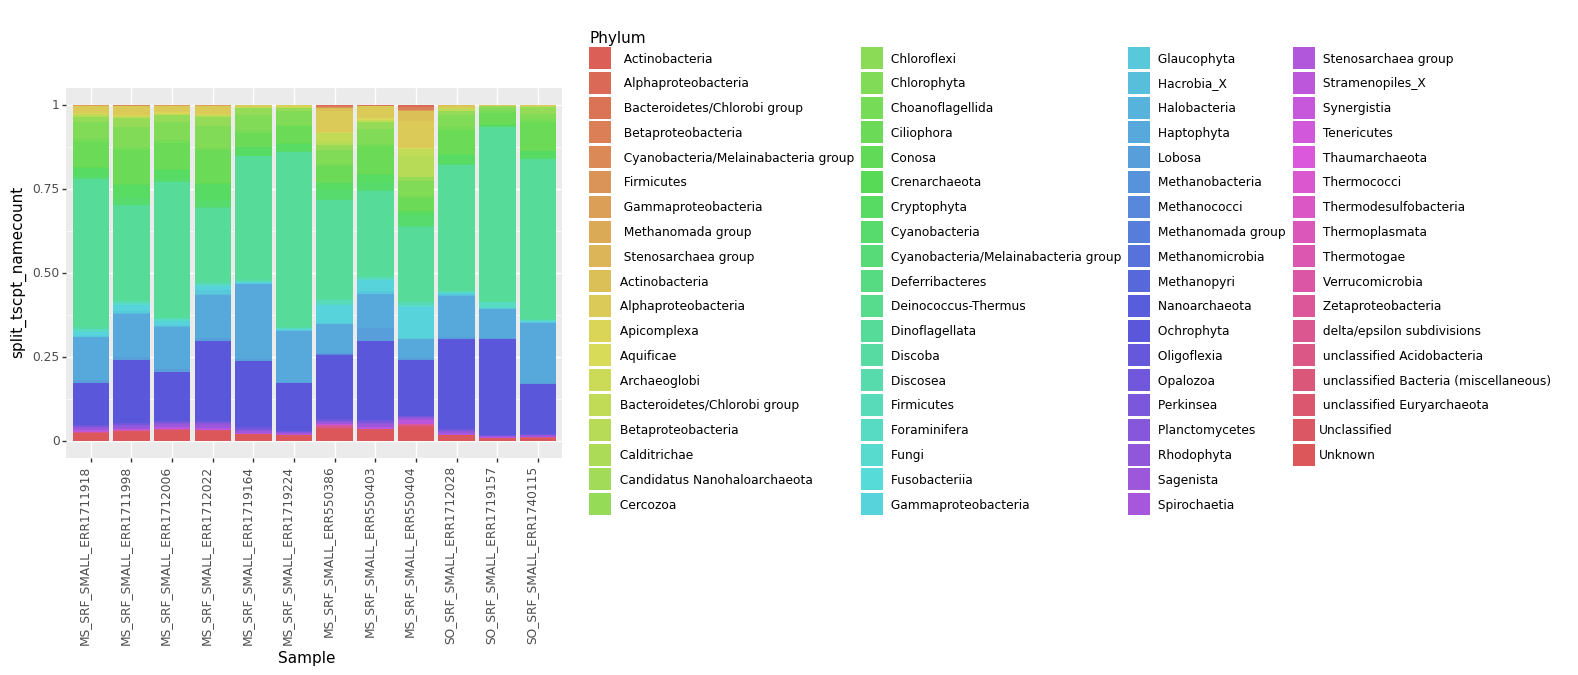

<ggplot: (2932513525297)>

In [9]:
(plotnine.ggplot(EUKulele_frame) + plotnine.geom_bar(plotnine.aes(x="Sample",y="split_tscpt_namecount",
                                                                  fill="Phylum"),
                                                     stat="identity",position="fill")+
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1)) )

In [ ]:
salmon_frame = pd.DataFrame()
for curr_folder in os.listdir(os.path.join(output_dir,'EUKulele_assemblers')):
    curr_assembler = curr_folder.split("EUKulele_")[-1]
    for curr_file in os.listdir(os.path.join(output_dir,'EUKulele_assemblers',curr_folder,"taxonomy_estimation")):
        curr_sample = curr_file.split("_" + curr_assembler)[0]
        salmon_file = pd.read_csv(os.path.join(salmon_dir,curr_sample+"_"+curr_assembler+"_quant",
                                               "quant.sf"),sep="\t")
        salmon_file["Sample"] = curr_sample
        salmon_file["Assembler"] = curr_assembler
        salmon_frame = pd.concat([salmon_frame,salmon_file])

In [95]:
salmon_file

,Name,Length,EffectiveLength,TPM,NumReads
0,megahit_MS_SRF_SMALL_ERR1719224_k111_283553,442,250.604,0.175315,7.743
1,megahit_MS_SRF_SMALL_ERR1719224_k111_283556,1341,1147.941,0.109365,22.125
2,megahit_MS_SRF_SMALL_ERR1719224_k111_56734,306,123.568,0.156206,3.402
3,megahit_MS_SRF_SMALL_ERR1719224_k111_170153,406,215.703,0.036092,1.372
4,megahit_MS_SRF_SMALL_ERR1719224_k111_340292,704,510.998,0.934297,84.139
...,...,...,...,...,...
3973602,trinity_MS_SRF_SMALL_ERR1719224_TRINITY_DN1101...,397,207.085,0.068501,2.500
3973603,trinity_MS_SRF_SMALL_ERR1719224_TRINITY_DN1107...,227,61.194,0.152634,1.646
3973604,trinity_MS_SRF_SMALL_ERR1719224_TRINITY_DN1106...,222,57.732,0.294855,3.000
3973605,trinity_MS_SRF_SMALL_ERR1719224_TRINITY_DN1105...,219,55.679,0.203819,2.000


In [21]:
EUKulele_frame_CAG = pd.DataFrame()
EUKulele_frame_full_CAG = pd.DataFrame()
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/09-CAG-mapping/salmon"
curr_assembler = "CAG"
curr_file = os.listdir(os.path.join(output_dir,'EUKulele_merged',"taxonomy_estimation"))[1]
curr_sample = curr_file.split("_" + curr_assembler)[0].split("_merged")[0]
EUKulele_file = pd.read_csv(os.path.join(output_dir,'EUKulele_merged',
                                                 "taxonomy_estimation",curr_file),sep="\t")
EUKulele_file["split_tscpt_name"] = EUKulele_file['transcript_name']
#EUKulele_file[["AssemblerSamp",
#               "split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split("_", 
#                                                                                 n=1, expand=True)

In [24]:
EUKulele_file.TPM.sum()

999999.9789490001

In [10]:
salmon_file = pd.read_csv(os.path.join(salmon_dir,curr_sample+"_quant",
                                               "quant.sf"),sep="\t")

In [23]:
EUKulele_file = pd.merge(EUKulele_file.drop_duplicates(),salmon_file,
                         left_on="split_tscpt_name",right_on="Name",
                         how = "right")

In [37]:
EUKulele_frame_CAG[EUKulele_frame_CAG.Phylum == "Unclassified"]

,Order,Domain,Phylum,Class,Family,Genus,TPMcount,TPMsum,Sample,Assembler
1114,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,5021632,721618.894740,MS_SRF_SMALL_ERR1711918,CAG
1145,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,5869058,663703.532819,MS_SRF_SMALL_ERR1711998,CAG
1041,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,2122885,569397.449397,MS_SRF_SMALL_ERR1719164,CAG
949,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,1767743,493167.005363,SO_SRF_SMALL_ERR1740115,CAG
999,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,1251813,526568.482339,SO_SRF_SMALL_ERR1712028,CAG
1025,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,3325702,452350.467241,SO_SRF_SMALL_ERR1740130,CAG
951,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,277622,550858.462103,MS_SRF_SMALL_ERR550403,CAG
1133,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,2159857,951713.285166,MS_SRF_SMALL_ERR1711995,CAG
988,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,2207830,571397.258177,MS_SRF_SMALL_ERR1719224,CAG
1139,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,4388246,634449.814210,MS_SRF_SMALL_ERR550396,CAG


In [28]:
EUKulele_frame_CAG.groupby(["Sample"]).TPMsum.sum()

Sample
MS_SRF_SMALL_ERR1711918    3.000000e+06
MS_SRF_SMALL_ERR1711995    3.000000e+06
MS_SRF_SMALL_ERR1711998    3.000000e+06
MS_SRF_SMALL_ERR1712006    3.000000e+06
MS_SRF_SMALL_ERR1712022    3.000000e+06
MS_SRF_SMALL_ERR1719164    3.000000e+06
MS_SRF_SMALL_ERR1719224    3.000000e+06
MS_SRF_SMALL_ERR550396     3.000000e+06
MS_SRF_SMALL_ERR550403     3.000000e+06
SO_SRF_SMALL_ERR1712028    3.000000e+06
SO_SRF_SMALL_ERR1740115    3.000000e+06
SO_SRF_SMALL_ERR1740130    3.000000e+06
Name: TPMsum, dtype: float64

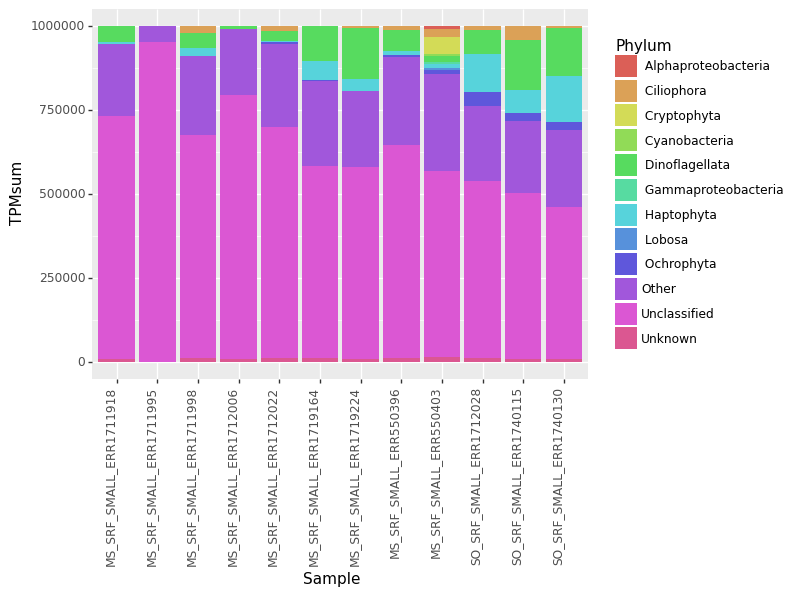

<ggplot: (2935532235584)>

In [35]:
EUKulele_frame_CAG_unique = EUKulele_frame_CAG.drop_duplicates().copy(deep=True)
EUKulele_frame_CAG_unique.loc[EUKulele_frame_CAG_unique.TPMsum<5000,"Phylum"] = "Other"
(plotnine.ggplot(EUKulele_frame_CAG_unique) + 
    plotnine.geom_bar(plotnine.aes(x="Sample",y="TPMsum",fill="Phylum"),
                                                        stat="identity")+
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=1)))

In [31]:
for curr_folder in os.listdir(os.path.join(output_dir,'EUKulele_merged'))[1]:
    print("yo!")

yo!
yo!
yo!


In [25]:
EUKulele_frame_CAG = pd.DataFrame()
#EUKulele_frame_full_CAG = pd.DataFrame()
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_tara/intermediate-files/04-compare/09-CAG-mapping/salmon"

curr_assembler = "CAG"
for curr_file in os.listdir(os.path.join(output_dir,'EUKulele_merged',"taxonomy_estimation")):
    curr_sample = curr_file.split("_" + curr_assembler)[0].split("_merged")[0]
    EUKulele_file = pd.read_csv(os.path.join(output_dir,'EUKulele_merged',
                                             "taxonomy_estimation",curr_file),sep="\t")
    #EUKulele_file[["AssemblerSamp",
    #               "split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split("_", 
    #                                                                                n=1, expand=True)
    #EUKulele_file["split_tscpt_name"] = [curr.split(curr_sample + "_")[-1] for curr in \
    #                                     EUKulele_file["transcript_name"]]
    EUKulele_file["split_tscpt_name"] = EUKulele_file['transcript_name'].drop_duplicates()
    salmon_file = pd.read_csv(os.path.join(salmon_dir,curr_sample+"_quant",
                                           "quant.sf"),sep="\t")
    EUKulele_file = pd.merge(EUKulele_file.drop_duplicates(),salmon_file,
                             left_on="split_tscpt_name",right_on="Name",
                             how = "right")
    EUKulele_file.loc[EUKulele_file.full_classification != EUKulele_file.full_classification,
                      "full_classification"] = "Unclassified;Unclassified;Unclassified;" + \
                "Unclassified;Unclassified;Unclassified;Unclassified;Unclassified"
    class_labels = ["Domain","Supergroup","Phylum","Class","Order",
                "Family","Genus","Species"]
    EUKulele_file[class_labels]= EUKulele_file["full_classification"].\
                                        str.split(";", n = 8, expand = True)
    #for class_label in class_labels:
    #    EUKulele_file.loc[EUKulele_file[class_label].isnull(),class_label] = "Unknown"
    EUKulele_file = EUKulele_file.fillna(value="Unknown")
        #EUKulele_file.loc[[curr is None for curr in EUKulele_file[class_label]],class_label] = "Unknown"
    EUKulele_file_full = EUKulele_file.copy(deep=True)
    EUKulele_file_full["Sample"] = curr_sample
    EUKulele_file_full["Assembler"] = curr_assembler
    EUKulele_file = EUKulele_file.groupby(["Order","Domain",
                                           "Phylum","Class","Family","Genus"]).agg({'TPM': ['count',
                                                                           'sum']}).reset_index()
    #EUKulele_file = EUKulele_file.groupby(["Order","Domain",
    #                                       "Phylum","Class","Family","Genus"]).agg({'split_tscpt_name': ['count']}).reset_index()
    EUKulele_file.columns = ["".join(col) for col in EUKulele_file.columns.values]
    EUKulele_file["Sample"] = curr_sample
    EUKulele_file["Assembler"] = curr_assembler
    print(curr_sample,curr_assembler,"done")
    EUKulele_frame_CAG = pd.concat([EUKulele_frame_CAG,EUKulele_file])
    #EUKulele_frame_full_CAG = pd.concat([EUKulele_frame_full_CAG,EUKulele_file_full])

MS_SRF_SMALL_ERR1711918 CAG done
MS_SRF_SMALL_ERR1711998 CAG done
MS_SRF_SMALL_ERR1719164 CAG done
SO_SRF_SMALL_ERR1740115 CAG done
SO_SRF_SMALL_ERR1712028 CAG done
SO_SRF_SMALL_ERR1740130 CAG done
MS_SRF_SMALL_ERR550403 CAG done
MS_SRF_SMALL_ERR1711995 CAG done
MS_SRF_SMALL_ERR1719224 CAG done
MS_SRF_SMALL_ERR550396 CAG done
MS_SRF_SMALL_ERR1712022 CAG done
MS_SRF_SMALL_ERR1712006 CAG done
MS_SRF_SMALL_ERR1711918 CAG done
MS_SRF_SMALL_ERR1711998 CAG done
MS_SRF_SMALL_ERR1719164 CAG done
SO_SRF_SMALL_ERR1740115 CAG done
SO_SRF_SMALL_ERR1712028 CAG done
SO_SRF_SMALL_ERR1740130 CAG done
MS_SRF_SMALL_ERR550403 CAG done
MS_SRF_SMALL_ERR1711995 CAG done
MS_SRF_SMALL_ERR1719224 CAG done
MS_SRF_SMALL_ERR550396 CAG done
MS_SRF_SMALL_ERR1712022 CAG done
MS_SRF_SMALL_ERR1712006 CAG done
MS_SRF_SMALL_ERR1711918 CAG done
MS_SRF_SMALL_ERR1711998 CAG done
MS_SRF_SMALL_ERR1719164 CAG done
SO_SRF_SMALL_ERR1740115 CAG done
SO_SRF_SMALL_ERR1712028 CAG done
SO_SRF_SMALL_ERR1740130 CAG done
MS_SRF_SMALL_E

In [94]:
EUKulele_file.head()

,Order,Domain,Phylum,Class,Family,Genus,TPMcount,TPMsum,Sample,Assembler
0,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,3973607,1.000000e+06,MS_SRF_SMALL_ERR1719224,CAG


In [75]:
 EUKulele_file.head()['transcript_name'].str.split("_", 
                                                                                         n=1, expand=True)

,0,1
0,megahit,MS_SRF_SMALL_ERR1719164_k111_100013
1,megahit,MS_SRF_SMALL_ERR1719164_k111_10002
2,megahit,MS_SRF_SMALL_ERR1719164_k111_10018
3,megahit,MS_SRF_SMALL_ERR1719164_k111_100218
4,megahit,MS_SRF_SMALL_ERR1719164_k111_100327


In [77]:
EUKulele_file["full_classification"].\
                                            str.split(";", n = 8, expand = True)

""


In [79]:
curr_sample = curr_file.split("_" + curr_assembler)[0]
EUKulele_file = pd.read_csv(os.path.join(output_dir,'EUKulele_merged',
                                         "taxonomy_estimation",curr_file),sep="\t")
EUKulele_file[["AssemblerSamp",
               "split_tscpt_name"]] = EUKulele_file['transcript_name'].str.split("_", 
                                                                                 n=1, expand=True)

In [82]:
class_labels = ["Domain","Supergroup","Phylum","Class","Order",
                    "Family","Genus","Species"]
EUKulele_file[class_labels]= EUKulele_file["full_classification"].\
                                    str.split(";", n = 8, expand = True)
EUKulele_file.head()

,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,AssemblerSamp,split_tscpt_name,Domain,Supergroup,Phylum,Class,Order,Family,Genus,Species
0,0,megahit_MS_SRF_SMALL_ERR1719164_k111_100013,family,Eukaryota; Alveolata; Dinoflagellata; Dinophyc...,Thoracosphaeraceae,69.8,0,NaN,megahit,MS_SRF_SMALL_ERR1719164_k111_100013,Eukaryota,Alveolata,Dinoflagellata,Dinophyceae,Peridiniales,Thoracosphaeraceae,None,None
1,0,megahit_MS_SRF_SMALL_ERR1719164_k111_10002,family,Eukaryota; Alveolata; Dinoflagellata; Dinophyc...,Suessiaceae,75.9,0,NaN,megahit,MS_SRF_SMALL_ERR1719164_k111_10002,Eukaryota,Alveolata,Dinoflagellata,Dinophyceae,Suessiales,Suessiaceae,None,None
2,0,megahit_MS_SRF_SMALL_ERR1719164_k111_10018,family,Eukaryota; Hacrobia; Haptophyta; Prymnesiophyc...,Phaeocystaceae,76.2,0,NaN,megahit,MS_SRF_SMALL_ERR1719164_k111_10018,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,Phaeocystales,Phaeocystaceae,None,None
3,0,megahit_MS_SRF_SMALL_ERR1719164_k111_100218,class,Eukaryota; Alveolata; Dinoflagellata; Dinophyceae,Dinophyceae,37.3,0,NaN,megahit,MS_SRF_SMALL_ERR1719164_k111_100218,Eukaryota,Alveolata,Dinoflagellata,Dinophyceae,None,None,None,None
4,0,megahit_MS_SRF_SMALL_ERR1719164_k111_100327,domain,Eukaryota,Eukaryota,97.5,1,NaN,megahit,MS_SRF_SMALL_ERR1719164_k111_100327,Eukaryota,None,None,None,None,None,None,None


In [83]:
EUKulele_file = EUKulele_file.fillna("Unknown")

In [87]:
EUKulele_file.groupby(["Phylum","Order"])["transcript_name"].count().reset_index().sort_values("transcript_name",
                                                                                              ascending=False)

,Phylum,Order,transcript_name
133,Dinoflagellata,Gymnodiniales,210912
188,Haptophyta,Prymnesiales,174131
136,Dinoflagellata,Peridiniales,125589
132,Dinoflagellata,Gonyaulacales,122044
139,Dinoflagellata,Unknown,114068
...,...,...,...
17,Firmicutes,Lactobacillales,1
246,Tenericutes,Mycoplasmatales,1
111,Crenarchaeota,Thermoproteales,1
13,Cyanobacteria/Melainabacteria group,Nostocales,1


In [88]:
sum(EUKulele_file.groupby(["Phylum",
                           "Order"])["transcript_name"].count().reset_index().sort_values("transcript_name",
                                                                                          ascending=False).transcript_name)

1635112